## Imports & Functions

In [30]:
def get_ids(bedfile, tr_id_field=20, sample_id_field=4, mode='one_iso_per_gene'):
    """
    Extracts information about entries in a bedfile and creates a dataframe from it.
    """
    file = bt.BedTool(bedfile)
    data_list = []

    #loop over rows/intervals of bedfile to gather info
    for interval in file:

        #gather info from interval object (row) of the bedtool object 
        chr = interval.chrom
        start = interval.start
        end = interval.end
        sample_id = interval.fields[3]
        gene_id = interval.fields[tr_id_field].split(';')[0]
        tr_id = interval.fields[tr_id_field].split(';')[1]
        info = interval.fields[tr_id_field].split(';')[2:]

        #fetch sequence corresponding to genomic coordinates in bed file
        #location = str(str(chr) + ':' + str(start) + '-' + str(end))
        #seq = bt.bedtool.BedTool.seq(location, genome_fasta)

        #create list of dictionaries containing information about interval
        data_list.append({'chr': chr, 'start': start, 'end': end , 'sample_id': sample_id, 'Gene stable ID version': gene_id.split('"')[1], 'Transcript stable ID version': tr_id.split('"')[1], 'info': info})
        
    
    #create pandas df from list of dictionaries
    data = pd.DataFrame(data_list, columns=['chr', 'start', 'end','sample_id', 'Gene stable ID version', 'Transcript stable ID version', 'info'])
    
    #convert type of sample_id column to int64 for later merging
    data['sample_id'] = data['sample_id'].astype('int64')
    
    return data


def merge_ids(tr_id_data, rl_data):
    """
    Merges two dataframes on the 'sample_id' column and adds for transcript IDs and gene IDs without version specification.
    """
    #assign sample et al 5UTR ID to seq as new column
    rl_data['sample_id'] = rl_data.index

    #merge dataframes based on sample et al 5UTR ID column
    merged_data = pd.merge(rl_data, tr_id_data, on='sample_id', how='inner')

    #remove ID versions in merged dataframe
    merged_data_copy = merged_data.copy()
    
    for i, row in merged_data_copy.iterrows():
        merged_data_copy.at[i, 'Transcript stable ID'] = row['Transcript stable ID version'].split('.')[0]
        merged_data_copy.at[i, 'Gene stable ID'] = row['Gene stable ID version'].split('.')[0]

    return merged_data_copy


def collapse_transcripts(data, val_col='rl', dup_col='Gene stable ID', mode='mean'):
    """
    sums translation values from all transcripts of a gene an returns a dataframe containing only genes
    for correlation on gene-level quantifications of translation
    """
    #keep only MRL value from transcript with highest expression per gene
    if mode=='highest':
        data_sorted = data.sort_values(by=val_col, ascending=False)
        data_filtered = data_sorted.drop_duplicates(subset=[dup_col], keep='first')

    #take average MRL across transcripts of the same gene
    elif mode=='mean':
        data_filtered = data.groupby('Gene stable ID')['rl'].mean().reset_index()

    #sum up MRL values for all transcripts of the same gene
    elif mode=='sum':
        data_filtered = data.groupby('Gene stable ID')['rl'].sum().reset_index()

    return data_filtered


def r(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue, 4)

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import pybedtools as bt

from Bio import SeqIO, Align
from sklearn import preprocessing

seed = 42
np.random.seed(seed)

path = '/fast/AG_Ohler/frederick/projects/mpra/mrl_te_comparison'

## Preprocessing Riboseq + RNAseq from ORFquant paper

First, we will preprocess Riboseq + RNAseq data obtained from the orfquant paper (https://doi.org/10.1038/s41594-020-0450-4)
1. Choose all transcripts with ORFs_pM > 1
3. Choose all genes with RNAseq TPM > 1
4. Merge rpf df, rna df and sequence df via transcript id
5. There are multiple ORFs per transcript. Choose ORF with highest ORFs_pM value per gene.
6. Calculate TE by dividing the normalized read counts. Perform log2-transform of the resulting TE values.

In [5]:
#import the rpf orfpm counts
rpf = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/riboseq/hek-orfquant-orfpm.tsv', sep='\t')[['transcript_id', 'gene_id', 'gene_name', 'region.start', 'region.end','ORFs_pM']]

#keep ORF with highest ORFs_pM per gene
len_before = len(rpf)


#keep only ORFs with ORFs_pM > 1
rpf = rpf[rpf['ORFs_pM']>=1].reset_index(drop=True)
len_after_1 = len(rpf)

print('Before removal of multiple transcripts per gene: '+str(len_before))
print('After keeping only transcripts with ORFs_pM > 1: '+str(len_after_1))

Before removal of multiple transcripts per gene: 20816
After keeping only transcripts with ORFs_pM > 1: 18939


In [7]:
#import the rnaseq tpm counts
rna = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/riboseq/hek-rnaseq-tpm.tsv',sep='\t')
bef_len = len(rna)

#remove transcripts with tpm<1
rna = rna[rna['tpm']>1]
aft_len = len(rna)

#rename target_id column to transcript_id
rna = rna.rename(columns={'target_id':'transcript_id'})

print('Before removal of any transcripts: '+str(bef_len))
print('After keeping only transcripts with TPM > 1: '+str(aft_len))

Before removal of any transcripts: 198093
After keeping only transcripts with TPM > 1: 27351


In [10]:
#import the 5utr sequences from fasta (extracted from hg38 release 25 annotation) and make dataframe
seq_ids = []
seqs = []

for seq in SeqIO.parse('/fast/AG_Ohler/frederick/projects/mlcis/data/riboseq/5utrs.fa', 'fasta'):
    seq_ids.append(str(seq.id))
    seqs.append(str(seq.seq))

utr = pd.DataFrame({'transcript_id':seq_ids, 'five_utr':seqs})

print('There are '+str(len(utr))+' 5utrs in the utr dataframe before merging with rpf and rnaseq.')

There are 78899 5utrs in the utr dataframe before merging with rpf and rnaseq.


In [11]:
#merge all three dataframes on transcript_id column

#rpf+ rna
te_data = rpf.merge(rna, on='transcript_id')
print('There are '+str(len(te_data))+' left after merging rpf and rnaseq.')

#add 5utr sequences
utr_data = te_data.merge(utr, on='transcript_id')

print('There are '+str(len(utr_data))+' entries in the final dataframe.')

There are 10433 left after merging rpf and rnaseq.
There are 9419 entries in the final dataframe.


In [12]:
#collapse to gene level; keep transcript with highest ORFs_pM count per gene
utr_data = utr_data.sort_values('ORFs_pM', ascending=False).drop_duplicates('gene_id').sort_index()
len_after = len(utr_data)
print('After keeping only the transcript with highest ORFs_pM per gene: '+str(len_after))

After keeping only the transcript with highest ORFs_pM per gene: 7663


In [13]:
#Calculate Translation Efficiency
utr_data['log2TE'] = np.log2(utr_data['ORFs_pM']/utr_data['tpm'])

## Preprocessing MPRA Libraries

Steps to obtain Transcript IDs for MPRA libraries from Sample et al

1) Map library fasta as reads to genome with STAR -> Alignments.bam (specifying genomic locations and sample_id)
2) Remove features other than transcripts from the annotation -> genome.transcripts.gtf
3) Intersect Alignments.bam with genome.transcripts.gtf to obtain transcript and gene IDs for genomic locations in the bam file -> tr_id_intersect.bed
4) Process the resulting bed file here, to obtain table with sample_id and tr_id/gene_id -> tr_id_df
5) Merge with MRL dataset to obtain table with smaple_id, tr_id/gene_id and MRL value 

- [ ] run STAR for mrl50 in v3 setting since filterung was different so sample_id values are different, for now I use the saved csv files
- [ ] consider collapsing to gene level by pairwise alignment after merging via transcript_id

In [15]:
mrl25to100 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/mrl25to100/GSM4084997_varying_length_25to100.csv').drop('Unnamed: 0', axis=1)
mrl25to100 = mrl25to100.loc[mrl25to100.set == 'human']
mrl25to100 = mrl25to100.loc[mrl25to100.total_reads >= 10 ]  #select reporters with most reads similar to Sample et. al
mrl25to100 = mrl25to100.sort_values('total', ascending = False).reset_index(drop = True)

mrl50 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/mrl25to100/GSM3130443_designed_library.csv').drop('Unnamed: 0', axis=1)
mrl50 = mrl50[(mrl50['library'] == 'human_utrs') | (mrl50['library'] == 'snv')]
mrl50 = mrl50.sort_values('total', ascending = False).reset_index(drop = True).iloc[:25000] #select reporters with most reads

/tmp/ipykernel_119361/415521373.py:6: DtypeWarning: Columns (33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  mrl50 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/mrl25to100/GSM3130443_designed_library.csv').drop('Unnamed: 0', axis=1)


In [16]:
mrl25t100 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mpra/mrl_te_comparison/data/mrl_50.csv', index_col=0)
mrl50 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mpra/mrl_te_comparison/data/mrl_varlen.csv', index_col=0)

In [17]:
v3tr_id_df = get_ids(path + '/data/STAR/mrl_varlen/v3tr_mrl_varlen.bed')
v3mrl25to100 = merge_ids(v3tr_id_df, mrl25to100)
v3mrl25to100.rename(columns = {'Transcript stable ID':'transcript_id'}, inplace = True)
v3mrl25to100.rename(columns = {'Gene stable ID':'gene_id'}, inplace = True)
print('Number of transcripts in bed file for v3 (mrl25to100):', v3mrl25to100.shape[0])

v3mrl50_tr_id = get_ids(path + '/data/STAR/mrl_50/v3tr_mrl_50.bed')
v3mrl50 = merge_ids(v3mrl50_tr_id, mrl50)
v3mrl50.rename(columns = {'Transcript stable ID':'transcript_id'}, inplace = True)
v3mrl50.rename(columns = {'Gene stable ID':'gene_id'}, inplace = True)
print('Number of transcripts in bed file for v3 (mrl50):', v3mrl50.shape[0])

Number of transcripts in bed file for v3 (mrl25to100): 35761
Number of transcripts in bed file for v3 (mrl50): 24125


In [24]:
#remove version of id columns in utr_data
utr_data['transcript_id'] = utr_data['transcript_id'].str.split('.').str[0]
utr_data['gene_id'] = utr_data['gene_id'].str.split('.').str[0]

#merge (v3mrl) containing mpra utrs and transcript id with (utr_data) containing transcript id and te values
calviello_v3mrl50 = pd.merge(v3mrl50, utr_data, on='transcript_id')
calviello_v3mrl25to100 = pd.merge(v3mrl25to100, utr_data, on='transcript_id')



## Plot Correlation

### Before Collapsing to Gene-Level

0.0258

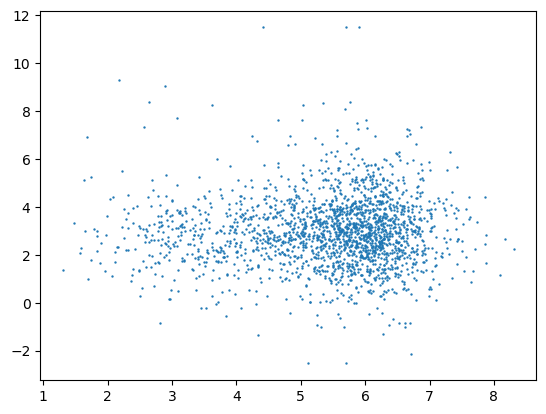

In [31]:
plt.scatter(calviello_v3mrl50['rl'], calviello_v3mrl50['log2TE'], s=0.5)
r(calviello_v3mrl50['rl'], calviello_v3mrl50['log2TE'])

-0.0246

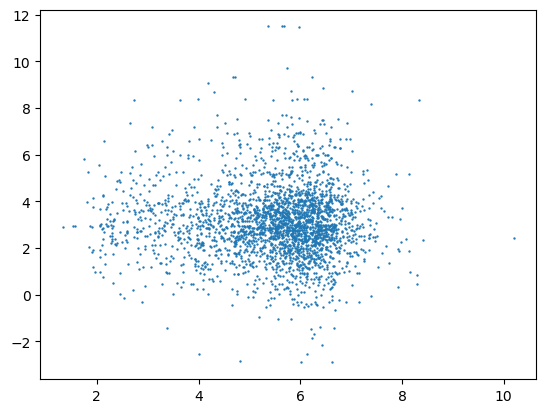

In [32]:
plt.scatter(calviello_v3mrl25to100['rl'], calviello_v3mrl25to100['log2TE'], s=0.5)
r(calviello_v3mrl25to100['rl'], calviello_v3mrl25to100['log2TE'])

### After Collapsing to Gene-Level by Highest MRL per gene

In [37]:
calviello_v3mrl50 = calviello_v3mrl50.sort_values(by='rl', ascending=False).drop_duplicates(subset=['gene_id_x'], keep='first')
calviello_v3mrl25to100 = calviello_v3mrl25to100.sort_values(by='rl', ascending=False).drop_duplicates(subset=['gene_id_x'], keep='first')

0.0091

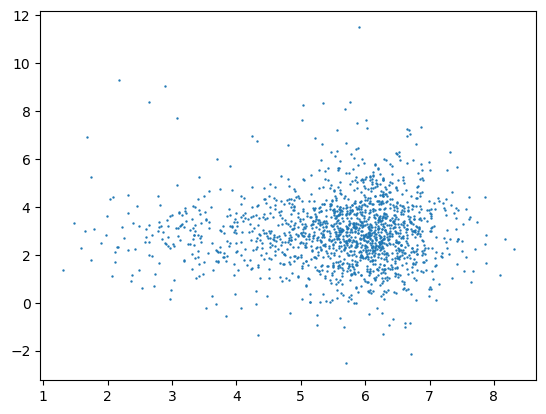

In [40]:
plt.scatter(calviello_v3mrl50['rl'], calviello_v3mrl50['log2TE'], s=0.5)
r(calviello_v3mrl50['rl'], calviello_v3mrl50['log2TE'])

-0.0105

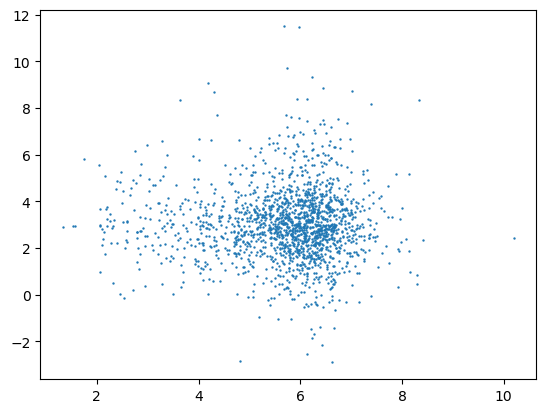

In [41]:
plt.scatter(calviello_v3mrl25to100['rl'], calviello_v3mrl25to100['log2TE'], s=0.5)
r(calviello_v3mrl25to100['rl'], calviello_v3mrl25to100['log2TE'])